In [1]:
setwd("E:\\PVN_Sequencing\\NEW_PVN_2016_Aligned83\\New_aligned_F1_Tophat83")
library(GenomicFeatures)
library(GenomicRanges)
library(Rsamtools)
library(GenomicAlignments)

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unlist, unsplit

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: IRanges
Loading required package: GenomeInfoDb
L

In [2]:
memory.limit(size=800000000)

## Use GenomicAlignments to read in aligned sequencing files
readsF1Br1=readGAlignments("F1_Beta_SGM4_Tophat.bam")
readsF1Br2=readGAlignments("F1_Beta_SGM8_Tophat.bam")
readsF1Br3=readGAlignments("F1_Beta_SGM12_Tophat.bam")
readsF1Br4=readGAlignments("F1_Beta_SGM16_Tophat.bam")
readsF1Br5=readGAlignments("F1_Beta_SGM20_Tophat.bam")
readsF1Cr1=readGAlignments("F1_Control_SGM3_Tophat.bam")
readsF1Cr2=readGAlignments("F1_Control_SGM7_Tophat.bam")
readsF1Cr3=readGAlignments("F1_Control_SGM11_Tophat.bam")
readsF1Cr4=readGAlignments("F1_Control_SGM15_Tophat.bam")
readsF1Cr5=readGAlignments("F1_Control_SGM19_Tophat.bam")
txdb=makeTxDbFromGFF("UNEWcuffmerge83_grep.gtf", format = "gtf")


[1] 8e+08

Import genomic features from the file as a GRanges object ... Warning message in open.connection(con, open):
"cannot open file 'UNEWcuffmerge83_grep.gtf': No such file or directory"

ERROR: Error in open.connection(con, open): cannot open the connection


In [3]:
txdb =makeTxDbFromGFF("F1ONLY_Cuffmerge_grep.gtf", format = 'gtf')

Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... OK


In [4]:
ex_by_gene<- exonsBy(txdb,'gene')

# Count how many sequenced reads overlap with exons
countsF1Br1= countOverlaps(ex_by_gene,readsF1Br1)
countsF1Br2= countOverlaps(ex_by_gene,readsF1Br2)
countsF1Br3= countOverlaps(ex_by_gene,readsF1Br3)
countsF1Br4= countOverlaps(ex_by_gene,readsF1Br4)
countsF1Br5= countOverlaps(ex_by_gene,readsF1Br5)
countsF1Cr1= countOverlaps(ex_by_gene,readsF1Cr1)
countsF1Cr2= countOverlaps(ex_by_gene,readsF1Cr2)
countsF1Cr3= countOverlaps(ex_by_gene,readsF1Cr3)
countsF1Cr4= countOverlaps(ex_by_gene,readsF1Cr4)
countsF1Cr5= countOverlaps(ex_by_gene,readsF1Cr5)
## Make Count Table
countTable<- data.frame(Control1=countsF1Cr1,Control2=countsF1Cr2, Control3=countsF1Cr3, Control4=countsF1Cr4,Control5=countsF1Cr5, Beta1=countsF1Br1,Beta2=countsF1Br2,Beta3=countsF1Br3,Beta4=countsF1Br4,Beta5=countsF1Br5, stringsAsFactors=FALSE)
x <- rowSums(countTable<=0)!=ncol(countTable)
newCountTable <- countTable[x,]

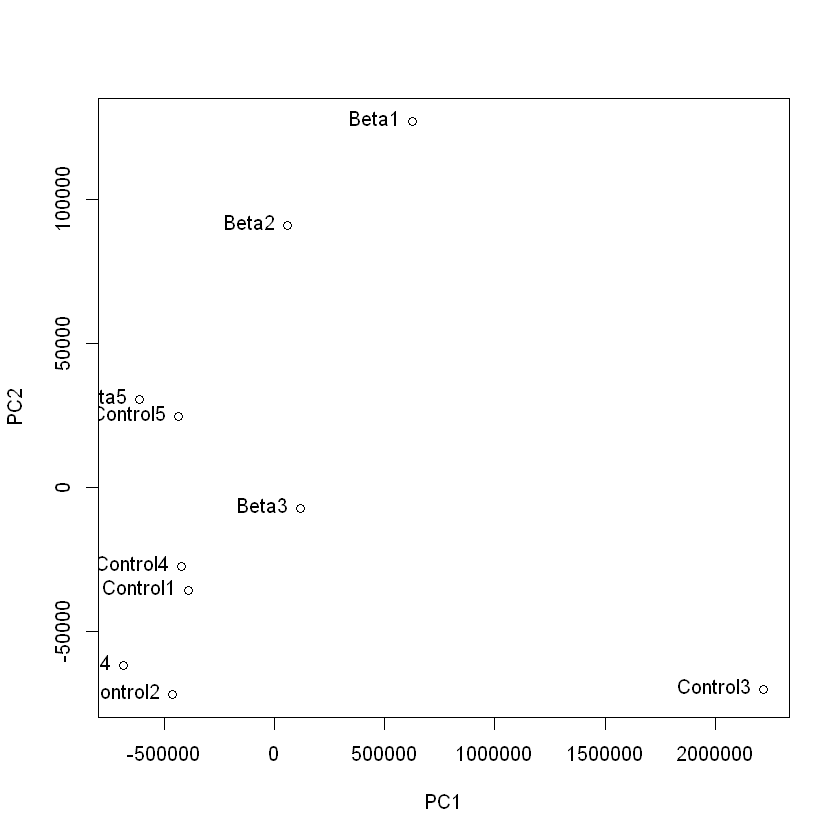

In [5]:
data<-newCountTable
## Get PCA of data
pca<-prcomp(t(as.matrix(data)))
plot(pca$x)
text(pca$x[,1], pca$x[,2], colnames(data), pos=2)
### This PCA shows that the majority of the variation in the dataset does not stem from the treatment group
### We will remove outliers to try and normalize the data such that the greatest variatin source is treatment group

In [6]:
## The first step is to filter out genes with low read counts, since sequencing is not accurate with low read counts
filter <- apply(data, 1, function(x) length(x[x>5])>=5)
filtered <- data[filter,]

In [7]:
library (DESeq2)
pheno<- read.csv("phenof1.csv", header=TRUE, row.names=1)
dds <- DESeqDataSetFromMatrix(countData = as.matrix(filtered),
colData = pheno,
design = ~ Treatment)
dds <- DESeq(dds)
res <- results(dds)
## find out how many outliers
summary(res)
## pull out Cooks Scores
maxCooks <- apply(assays(dds)[["cooks"]], 1, max)

Loading required package: Rcpp
Warning message:
"package 'Rcpp' was built under R version 3.2.5"Loading required package: RcppArmadillo
Warning message:
"package 'RcppArmadillo' was built under R version 3.2.5"estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing



out of 18449 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 1, 0.0054% 
LFC < 0 (down)   : 2, 0.011% 
outliers [1]     : 147, 0.8% 
low counts [2]   : 0, 0% 
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [15]:
## We have 147 outliers which will be removed from our dataset. 

data<- read.csv("cd_F1_PVN_NEW_zero_elim_filtered_OUTLIERS_lncRNA_ensRM_Names83_try2.csv", header=TRUE, row.names=1)



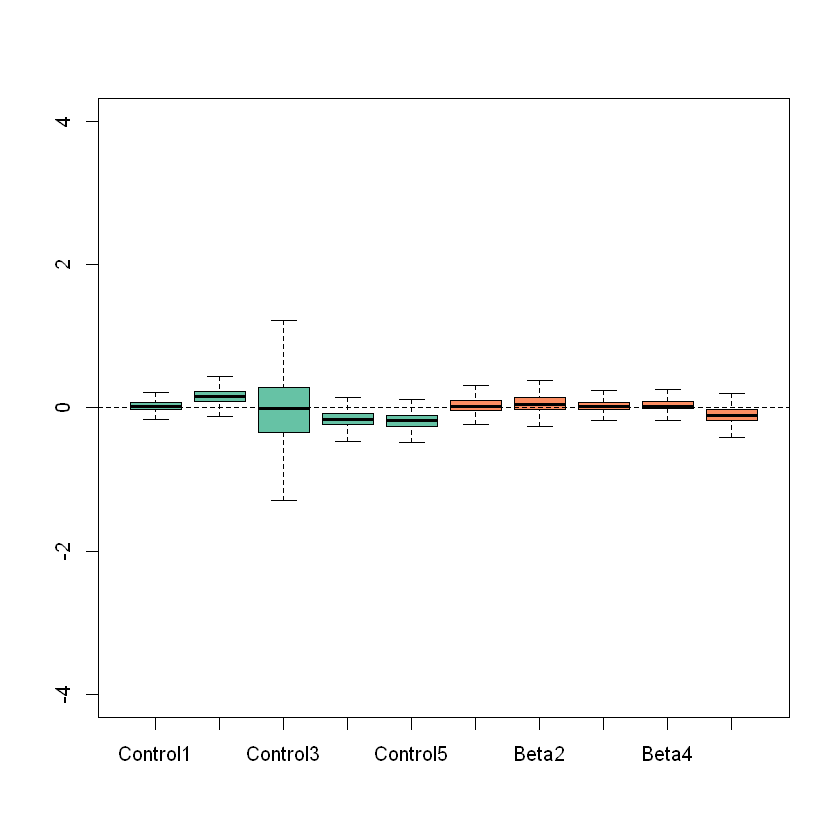

In [17]:
library(RUVSeq)
x <- as.factor(c(1,1,1,1,1,2,2,2,2,2))
set <- newSeqExpressionSet(as.matrix(data),
			phenoData = data.frame(x, row.names=colnames(data)))
genes <- rownames(data)		
libSizes <- as.vector(colSums(data))	

### RUV visualization 
library(RColorBrewer)
colors <- brewer.pal(3, "Set2")

### Plots: This shows us how much information we are getting from each sample. 
plotRLE(set, outline=FALSE, ylim=c(-4, 4), col=colors[x])
## As we can see in the image below, control 3 has a lot of variation in read count coverage

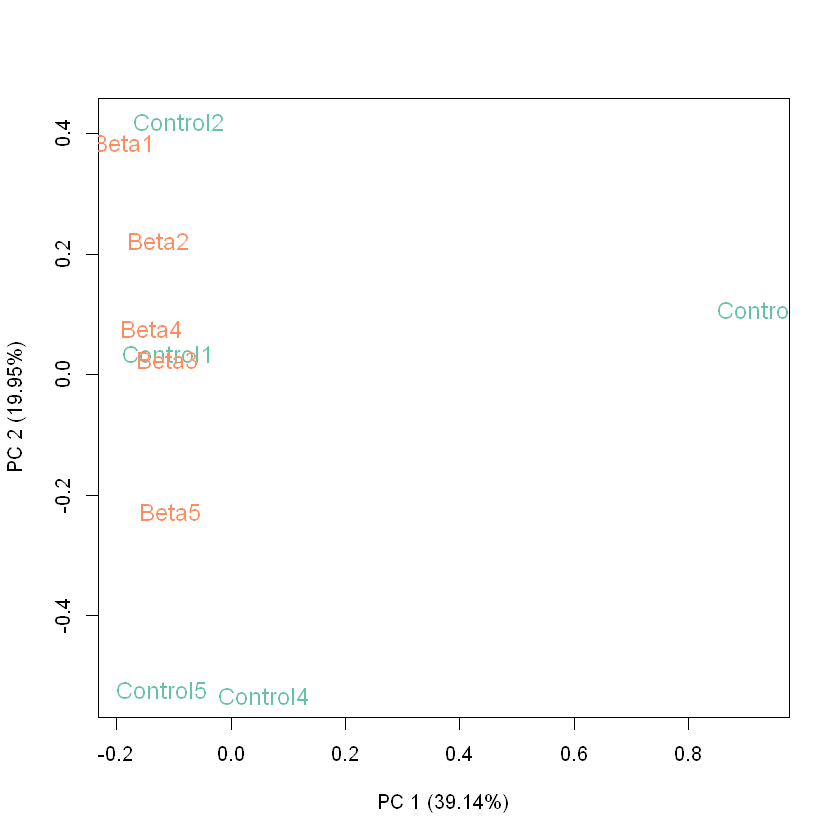

In [18]:
plotPCA(set, col=colors[x], cex=1.2)	

### This is the same PCA just confirming that the majority of the variation in our data set is coming from Control 3. 
## We will try to normalize by residuals to see if we can improve the PCA.


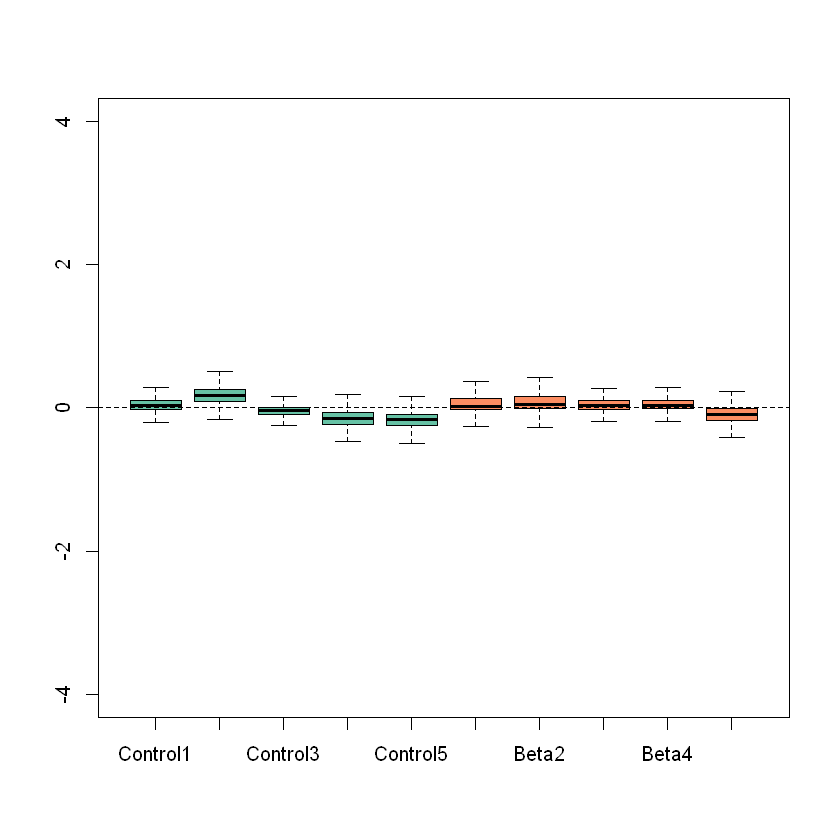

In [19]:
### RUVr normalize the data by residuals
design<- model.matrix(~x, data=pData(set))
y <- DGEList(counts=counts(set), group=x)
y <- calcNormFactors(y,method="upperquartile")
y <- estimateGLMCommonDisp(y, design)
y <- estimateGLMTagwiseDisp(y, design)
fit <- glmFit(y, design)
res <- residuals(fit, type="deviance")
set1<- RUVr(set, genes, k=1, res)

plotRLE(set1, outline=FALSE, ylim=c(-4, 4), col=colors[x])

### This RLE shows that major improvements have been made to our data

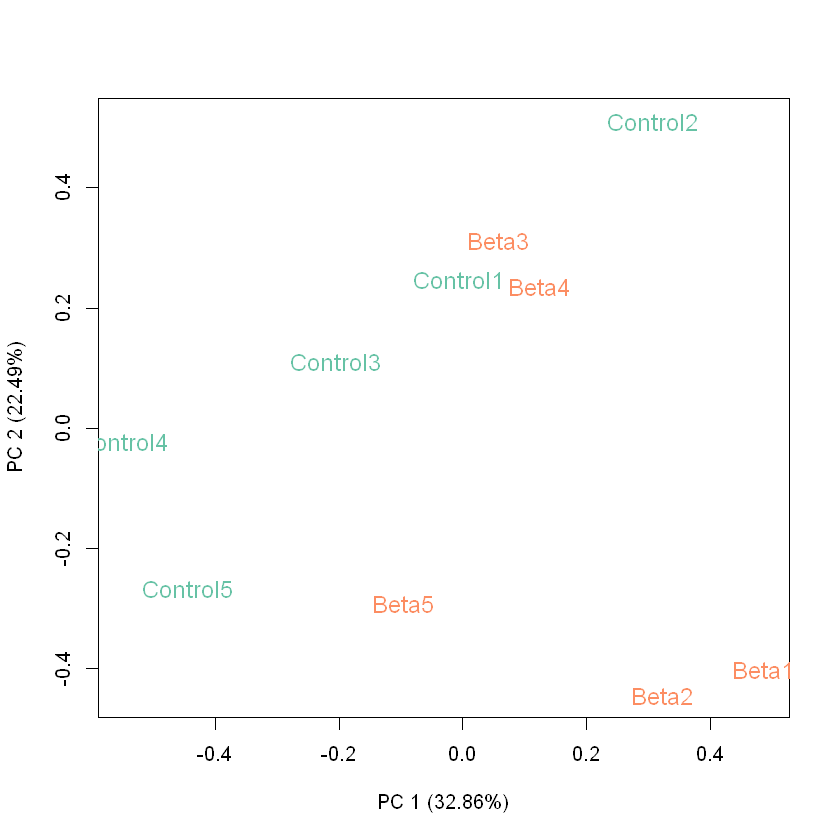

In [20]:
## Now we can check the PCA to see if our data separates by treatment group 
plotPCA(set1, col=colors[x], cex=1.2)		

In [ ]:
## The PCA shows that the majority of the variation is coming from the treatment group, while there are some control samples 
## that overlap to the treatment side. We will leave the data at this stage as we want to ensure that we are not over-fitting 
## the data normalization